<a href="https://colab.research.google.com/github/DmitryKostin/data-analysis-projects/blob/main/04_taxi_failed_orders_project/taxi_failed_orders_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Геоаналитика отмененных заказов такси Gett

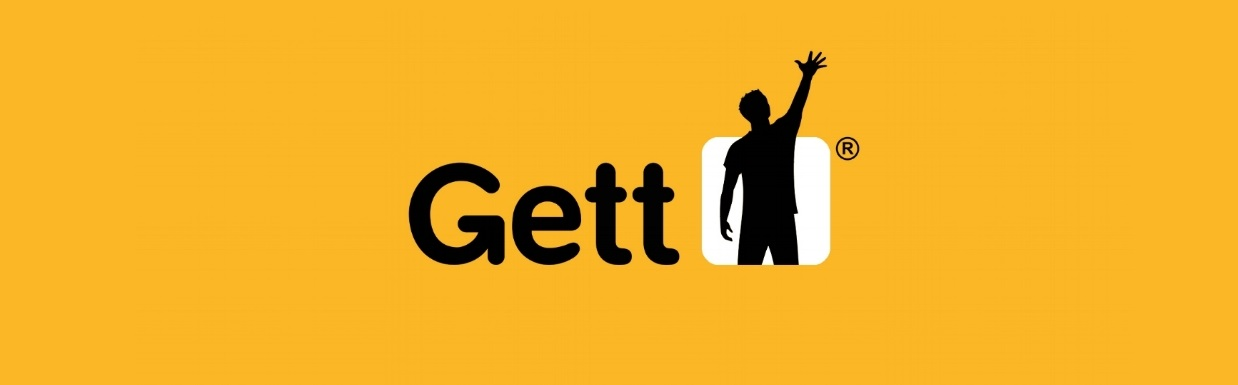

**Содержание** <a class='anchor' id='table_of_contents'></a>

* [Описание проекта](#description)
* [Описание данных](#data)
* [Шаг 1. Загрузка и изучение данных](#step_1)
* [Шаг 2. Предобработка данных](#step_2)
* [Шаг 3. Исследовательский анализ данных](#step_3)
  * [Распределение заказов по причинам отказа](#step_3_1)
  * [Распределение отмененных заказов по часам](#step_3_2)
  * [Среднее время до отмены заказа](#step_3_3)
  * [Распределение среднего ожидаемого время прибытия (ETA)](#step_3_4)
  * [Визуализация геоданных](#step_3_5)
* [Выводы](#final)

## Описание проекта <a class='anchor' id='description'></a>

Gett, ранее известная как GetTaxi, представляет собой разработанную в Израиле технологическую платформу, ориентированную исключительно на корпоративное управление наземным транспортом (GTM - Ground Transportation Management). В приложении Gett клиенты могут заказывать такси, а водители могут принимать заказы. В момент, когда клиент нажимает кнопку «Заказать» в приложении, система сопоставления ищет наиболее подходящих водителей и предлагает им заказ. В этом проекте исследуются некоторые метрики сопоставления для отмененных заказов - которые не были выполнены успешно, т. е. клиент не смог совершить поездку.

В проекте необходимо решить следующие задачи:

1. Исследовать распределение заказов по причинам отказа: отмены до и после назначения водителя, причины отклонения заказа. Определить, в какой категории больше всего заказов.
2. Построить распределение отмененных заказов по часам. Проверить, есть ли тенденция, что определенные часы имеют аномально высокую долю той или иной категории. Определить, в какие часы больше всего отмененных заказов и чем это вызвано.
3. Построить график среднего времени до отмены с водителем и без него по часам. Если в данных есть выбросы, лучше их удалить. Можно ли сделать какие-то выводы?
4. Построить распределение среднего ожидаемого времени прибытия (ETA) по часам. Какие выводы можно сделать?
5. Используя пакеты `h3` и `folium`, подсчитать, сколько шестигранников размера 8 содержат 80% всех отмененных заказов и визуализировать их, раскрасив по количеству отмен на карте.

## Описание данных <a class='anchor' id='data'></a>

У нас есть два набора данных: `data_orders` и `data_offers` в формате CSV. Датасет `data_orders` содержит следующие столбцы:

- `order_datetime` - время заказа
- `origin_longitude` - долгота точки заказа
- `origin_latitude` - широта точки заказа
- `m_order_eta` - время до прибытия заказа (ETA, Estimated Time of Arrival — ожидаемое время прибытия)
- `order_gk` - порядковый номер
- `order_status_key` - статус, перечисление, состоящее из следующего отображения:
  - `4` - отменено клиентом,
  - `9` - отменен системой, т.е. отклонен
- `is_driver_assigned_key`- назначен ли водитель
- `cancellation_time_in_seconds`- сколько секунд прошло до отмены

Датасет `data_offers` представляет собой простую карту с двумя столбцами:

- `order_gk` - номер заказа, связанный с тем же столбцом из датасета `orders`
- `offer_id` - ID предложения

[Назад к содержанию](#table_of_contents)

## Шаг 1. Загрузка и изучение данных <a id="step_1"></a> 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import h3
import folium
import json
import geojson

In [2]:
# функция для подсчета дубликатов и получения общих сведений о датасете
def get_info(data):
    display(data.head())
    print('Число дубликатов:', data.duplicated().sum())
    print()
    data.info()

In [3]:
# функция для подсчета доли пропусков
def get_na(data):
    na_info = (
        pd.DataFrame(data.isna().mean())
        .rename(columns={0: 'NaN'})
        .style
        .set_caption('Доля пропусков')
        .background_gradient('coolwarm')
        .format('{:.2%}')
        )
    return na_info

In [4]:
orders = pd.read_csv('data_orders.csv')

In [5]:
offers = pd.read_csv('data_offers.csv')

In [6]:
get_info(orders)

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0
4,21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,NaN


Число дубликатов: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10716 entries, 0 to 10715
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_datetime                 10716 non-null  object 
 1   origin_longitude               10716 non-null  float64
 2   origin_latitude                10716 non-null  float64
 3   m_order_eta                    2814 non-null   float64
 4   order_gk                       10716 non-null  int64  
 5   order_status_key               10716 non-null  int64  
 6   is_driver_assigned_key         10716 non-null  int64  
 7   cancellations_time_in_seconds  7307 non-null   float64
dtypes: float64(4), int64(3), object(1)
memory usage: 669.9+ KB


In [7]:
get_na(orders)

,NaN
order_datetime,0.00%
origin_longitude,0.00%
origin_latitude,0.00%
m_order_eta,73.74%
order_gk,0.00%
order_status_key,0.00%
is_driver_assigned_key,0.00%
cancellations_time_in_seconds,31.81%


Имеется значимое количество пропусков в столбце `m_order_eta` - 73.74%. Данный столбец отражает временные значения, в связи с чем невозможно наиболее точно заполнить подобные пропуски. Аналогично и со столбцом `cancellations_time_in_seconds`, имеющем 31.81% пропусков. Оставим пропуски в этих столбцах. Дубликатов в датафрейме `orders` не найдено.

In [8]:
get_info(offers)

,order_gk,offer_id
0,3000579625629,300050936206
1,3000627306450,300052064651
2,3000632920686,300052408812
3,3000632771725,300052393030
4,3000583467642,300051001196


Число дубликатов: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334363 entries, 0 to 334362
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   order_gk  334363 non-null  int64
 1   offer_id  334363 non-null  int64
dtypes: int64(2)
memory usage: 5.1 MB


In [9]:
get_na(offers)

,NaN
order_gk,0.00%
offer_id,0.00%


Пропусков и дубликатов в датафрейме `offers` не найдено.

[Назад к содержанию](#table_of_contents)

## Шаг 2. Предобработка данных <a class='anchor' id='step_2'></a>

Выполним слияние датафреймов `orders` и `offers` по столбцу с порядковым идентификатором заказа `order_gk`.

In [10]:
data = orders.merge(right=offers, how='inner', on='order_gk')

In [11]:
data.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,offer_id
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0,300050983403
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,300050986179
2,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,300050986174
3,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,300050986180
4,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0,300050976275


Значения столбцов `order_status_key` и `is_driver_assigned_key` представлены бинарным кодом - 1 и 0. Для удобства заменим эти значения на `Yes` и `No` в обоих столбцах.

In [12]:
data['is_driver_assigned'] = np.where(data['is_driver_assigned_key'] == 1, 'Yes', 'No')
data['order_status'] = np.where(data['order_status_key'] == 4, 'Client Cancelled', 'System Reject')

data.drop(columns=['is_driver_assigned_key', 'order_status_key'], inplace=True)

Переименуем столбец `order_datetime` в `order_time`.

In [13]:
data = data.rename(columns={
    'order_datetime': 'order_time'
})

In [14]:
data.head()

,order_time,origin_longitude,origin_latitude,m_order_eta,order_gk,cancellations_time_in_seconds,offer_id,is_driver_assigned,order_status
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,198.0,300050983403,Yes,Client Cancelled
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,128.0,300050986179,No,Client Cancelled
2,20:57:32,-0.950385,51.456843,NaN,3000583116437,128.0,300050986174,No,Client Cancelled
3,20:57:32,-0.950385,51.456843,NaN,3000583116437,128.0,300050986180,No,Client Cancelled
4,12:07:50,-0.969520,51.455544,477.0,3000582891479,46.0,300050976275,Yes,Client Cancelled


[Назад к содержанию](#table_of_contents)

## Шаг 3. Исследовательский анализ данных <a class='anchor' id='step_3'></a>

### Распределение заказов по причинам отказа <a class='anchor' id='step_3_1'></a>

Построим распределение заказов по причинам отказа: отмены до и после назначения водителя, причины отклонения заказа. Узнаем, в какой категории больше всего заказов.

Посмотрим сколько всего заказов в датасете.

In [15]:
print('Всего отмененных заказов:', len(data))

Всего отмененных заказов: 31268


Сгруппируем заказы по причинам отмены.

In [16]:
data.groupby(by=['is_driver_assigned', 'order_status'])['order_gk'].count()

is_driver_assigned  order_status    
No                  Client Cancelled    13435
                    System Reject        9469
Yes                 Client Cancelled     8360
                    System Reject           4
Name: order_gk, dtype: int64

Мы видим большое количество заказов (около 43% всех заказов), отмененных до того, как был назначен водитель. Это скорее всего означает, что клиенты ждали слишком долго и решили воспользоваться иным транспортом в своей поездке. Итого, мы можем зафиксировать 13 435 заказов, отмененных клиентом (42.9%), и 9 469 заказов,  отклоненных системой (30.3%). 8 360 заказов были отменены клиентами после назначения водителя (26.7%), и только 4  заказа были отклонены системой по какой-то иной причине (0.0001%).

Создадим сводную таблицу `cancelled_orders`, на основе которой визуализируем распределение отмененных заказов.

In [17]:
cancelled_orders = (data.
                    pivot_table(columns=['is_driver_assigned', 
                                         'order_status'], 
                                values='order_gk', 
                                aggfunc='count'))
cancelled_orders

is_driver_assigned               No                            Yes  \
order_status       Client Cancelled System Reject Client Cancelled   
order_gk                      13435          9469             8360   

is_driver_assigned                
order_status       System Reject  
order_gk                       4

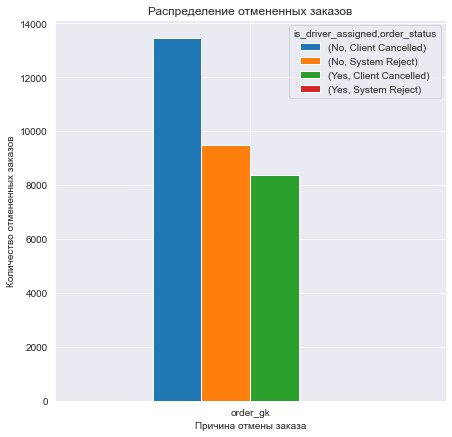

In [18]:
sns.set_style('darkgrid') 
cancelled_orders.plot(kind='bar', 
                      subplots=False, 
                      figsize=(7, 7), 
                      legend=True, 
                      rot=0)
plt.title('Распределение отмененных заказов')
plt.xlabel('Причина отмены заказа')
plt.ylabel('Количество отмененных заказов')
plt.show();

[Назад к содержанию](#table_of_contents)

### Распределение отмененных заказов по часам <a class='anchor' id='step_3_2'></a>

Построим распределение отмененных заказов по часам. Проверим, есть ли тенденция, что определенные часы имеют аномально высокую долю той или иной категории. Также узнаем, в какие часы больше всего отмененных заказов.

Помимо анализа распределения сбоев по категориям (причина отмены и назначение водителя), важно понять, когда происходят эти сбои, и есть ли какой-то определенный период дня, когда одна категория превалирует над другими.

Добавим столбец `order_hour` со значениями часа из столбца с временем заказа.

In [19]:
data['order_hour'] = data['order_time'].str.split(':').apply(lambda x: x[0])

In [20]:
data.head()

,order_time,origin_longitude,origin_latitude,m_order_eta,order_gk,cancellations_time_in_seconds,offer_id,is_driver_assigned,order_status,order_hour
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,198.0,300050983403,Yes,Client Cancelled,18
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,128.0,300050986179,No,Client Cancelled,20
2,20:57:32,-0.950385,51.456843,NaN,3000583116437,128.0,300050986174,No,Client Cancelled,20
3,20:57:32,-0.950385,51.456843,NaN,3000583116437,128.0,300050986180,No,Client Cancelled,20
4,12:07:50,-0.969520,51.455544,477.0,3000582891479,46.0,300050976275,Yes,Client Cancelled,12


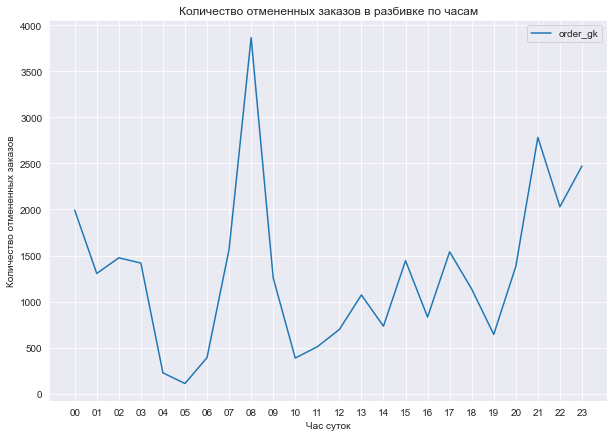

In [21]:
(data
 .groupby(by='order_hour')['order_gk']
 .count()
 .plot(figsize=(10, 7),
       legend=True,
       xticks=range(0, 24),
       title='Количество отмененных заказов в разбивке по часам'))

plt.xlabel('Час суток')
plt.ylabel('Количество отмененных заказов')
plt.show();

Максимальные значения отмененных заказов приходятся на утренние часы - в интервале с 6 до 9 часов. Во время час-пика происходит наибольшее количество - то же самое можно сказать и о вечерних часах, начиная с 20 часов.

Сгруппируем данные в разбивке по часам суток и причинам отмены заказа и построим график.

In [22]:
grouped_q2 = data.groupby(by=['order_hour', 'is_driver_assigned', 'order_status'])['order_gk'].count()
grouped_q2

order_hour  is_driver_assigned  order_status    
00          No                  Client Cancelled     957
                                System Reject        706
            Yes                 Client Cancelled     326
                                System Reject          4
01          No                  Client Cancelled     633
                                                    ... 
22          No                  System Reject        660
            Yes                 Client Cancelled     415
23          No                  Client Cancelled    1144
                                System Reject        883
            Yes                 Client Cancelled     444
Name: order_gk, Length: 73, dtype: int64

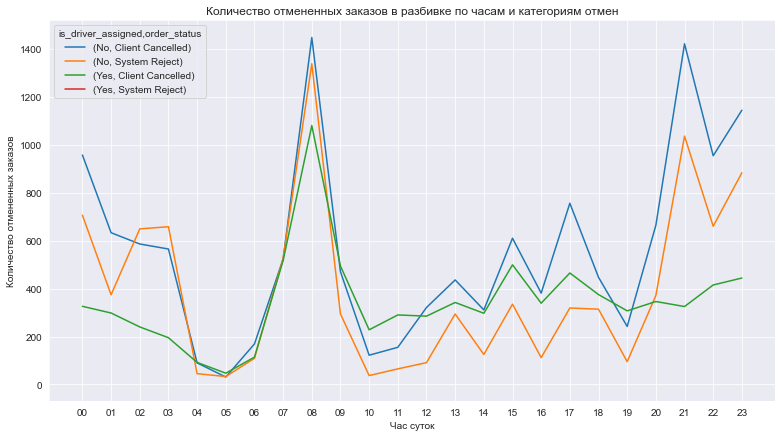

In [23]:
(grouped_q2
 .reset_index()
 .pivot(index='order_hour',
        columns=['is_driver_assigned', 
                 'order_status'],
        values='order_gk')
 .plot(xticks=range(0, 24),
       figsize=(13, 7),
       title='Количество отмененных заказов в разбивке по часам и категориям отмен'))

plt.xlabel('Час суток')
plt.ylabel('Количество отмененных заказов')
plt.show();

Четыре отказа системы (System Reject) с назначенным водителем произошли около полуночи. Остальные категории следуют аналогичному распределению, при этом количество отказов клиентов с назначенным водителем значительно меньше в ночное время.

[Назад к содержанию](#table_of_contents)

### Среднее время до отмены заказа <a class='anchor' id='step_3_3'></a>

Построим график среднего времени до отмены заказа с назначенным водителем и без него в разбивке по часам.

Сгруппируем данные по часу заказа и флагу назначения водителя. Затем рассчитаем среднее для столбца `cancellations_time_in_seconds`.

In [24]:
avg_cancel_time = data.groupby(by=['order_hour', 'is_driver_assigned'])['cancellations_time_in_seconds'].mean()
avg_cancel_time.head(10)

order_hour  is_driver_assigned
00          No                    115.126437
            Yes                   276.082822
01          No                    100.593997
            Yes                   296.312081
02          No                    121.305461
            Yes                   301.466667
03          No                    129.182301
            Yes                   368.682051
04          No                    100.733333
            Yes                   245.250000
Name: cancellations_time_in_seconds, dtype: float64

Построим график среднего времени до отмены заказы в разбивке по статусу водителя.

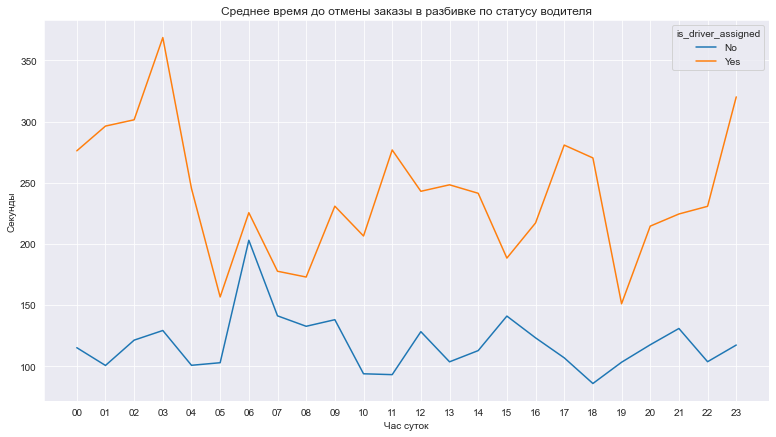

In [25]:
(avg_cancel_time
 .reset_index()
 .pivot(index='order_hour',
        columns='is_driver_assigned',
        values='cancellations_time_in_seconds')
 .plot(xticks=range(0, 24),
       figsize=(13, 7),
       title='Среднее время до отмены заказы в разбивке по статусу водителя'))

plt.xlabel('Час суток')
plt.ylabel('Секунды')
plt.show();

Среднее время до отмены заказов с назначенным водителем выше, чем без - в каждом часу без исключений. Пик приходится на 3 часа ночи. В это время происходит много отмен клиентов, поэтому логичным объяснением будет то, что клиенты слишком долго ждали водителя.

[Назад к содержанию](#table_of_contents)

### Распределение среднего ожидаемого время прибытия (ETA) <a class='anchor' id='step_3_4'></a>

Построим распределение среднего ETA (Estimated Time of Arrival — ожидаемое время прибытия) по часам.

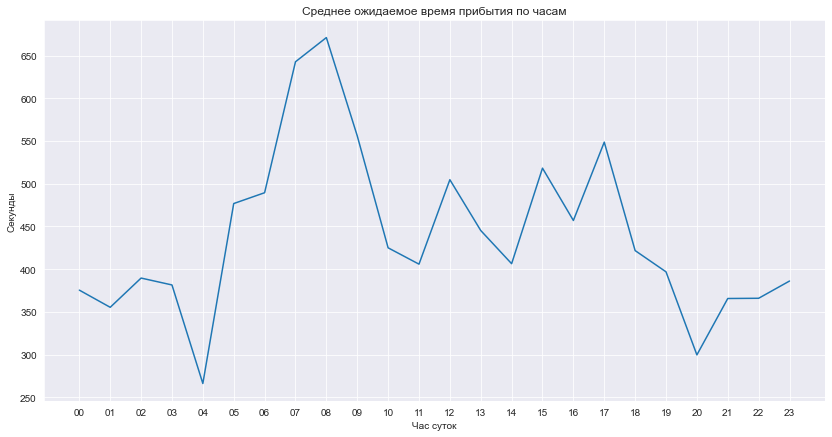

In [26]:
(data
 .groupby(by='order_hour')['m_order_eta']
 .mean()
 .plot(figsize=(14, 7),
       xticks=range(0, 24),
       title='Среднее ожидаемое время прибытия по часам'))

plt.xlabel('Час суток')
plt.ylabel('Секунды')
plt.show();

Дольше всего клиенты ждут прибытия такси в утренние часы с 6 до 9 часов - в среднем ожидание превышает 10 минут (более 650 секунд). В этом же интервале происходит подавляющее количество отмен заказов, что очевидно связано - из-за долгого ожидания клиенты отменяют заказы.

[Назад к содержанию](#table_of_contents)

### Визуализация геоданных <a class='anchor' id='step_3_5'></a>

Используя библиотеки `h3` и `folium`, подсчитаем, сколько шестигранников ("сот") размера 8 содержат 80% всех заказов из исходных наборов данных.  Визуализируем шестигранники, окрасив их по количеству отмененных заказов на карте.

Создадим столбец `hex_id` с уникальным идентификатором шестигранника, вычисленного по сгруппированым географическим координатам одного участка местности.

In [27]:
data['hex_id'] = data.apply(func=lambda row: h3.geo_to_h3(lat=row['origin_latitude'], 
                                                          lng=row['origin_longitude'], 
                                                          resolution=8), axis=1)

Сгруппируем данные по вычисленным областям и подсчитаем количество заказов в каждом шестиграннике.

In [28]:
grouped_hexes = data.groupby(by='hex_id')['order_gk'].count()
grouped_hexes.shape

(139,)

Всего получилось 139 шестигранников.

In [29]:
grouped_hexes = grouped_hexes.reset_index()
grouped_hexes.head()

,hex_id,order_gk
0,88195d2801fffff,65
1,88195d2803fffff,14
2,88195d2805fffff,10
3,88195d2807fffff,3
4,88195d2809fffff,46


Чтобы найти количество шестигранников, содержащих 80% заказов, применим кумулятивную процентную операцию к столбцу с количеством заказов `order_gk`.
 
Выполним следующие шаги:

- отсортируем датафрейм по заказам по возрастанию;
- найдем общее количество (сумму) невыполненных заказов;
- примените метод `cumsum`, чтобы найти совокупную сумму столбца количества заказов;
- разделим на общую сумму, чтобы получить проценты;
- отфильтруем строки, которые больше 80%.

In [30]:
grouped_hexes = grouped_hexes.sort_values(by='order_gk')
total_orders = grouped_hexes['order_gk'].sum()
grouped_hexes['cum_sum'] = grouped_hexes['order_gk'].cumsum()
grouped_hexes['cum_perc'] = 100 * grouped_hexes['cum_sum'] / total_orders
grouped_hexes[grouped_hexes['cum_perc'] <= 80] 

,hex_id,order_gk,cum_sum,cum_perc
137,88195d74d5fffff,1,1,0.003198
135,88195d74d1fffff,1,2,0.006396
79,88195d2aebfffff,1,3,0.009594
11,88195d282bfffff,1,4,0.012793
122,88195d3993fffff,1,5,0.015991
...,...,...,...,...
61,88195d2a27fffff,1295,15628,49.980811
20,88195d284dfffff,1937,17565,56.175643
91,88195d2b19fffff,1960,19525,62.444032
87,88195d2b11fffff,2191,21716,69.451196


В полученном выводе 137 строк, а в исходном сгруппированном датасете 139 строк. Это означает, что 137 шестиугольников содержат около 80% данных, и только 2 шестиугольника содержат остальные 20%.

Нанесем полученные шестигранники на карту.

In [31]:
map = folium.Map(location=[data['origin_latitude'].mean(), 
                           data['origin_longitude'].mean()],
                 zoom_start=12,
                 tiles='cartodbpositron')

In [32]:
# фукнция для трансформации hex_id в geojson объект

def to_geojson(row):
    geometry = {
        'type': 'Polygon',
        'coordinates': [h3.h3_to_geo_boundary(h=row['hex_id'], geo_json=True)]
    }
    return geojson.Feature(id=row['hex_id'], 
                           geometry=geometry, 
                           properties={'order_gk': row['order_gk']})


geojsons = grouped_hexes.apply(func=to_geojson, axis=1).values.tolist()
geojson_str: str = json.dumps(geojson.FeatureCollection(geojsons))

In [33]:
# загрузим палитру для визуализации
colormap = matplotlib.cm.get_cmap(name='plasma')
max_order_gk = grouped_hexes['order_gk'].max()
min_order_gk = grouped_hexes['order_gk'].min()

In [34]:
folium.GeoJson(data=geojson_str, style_function=lambda f: {
    'fillColor': matplotlib.colors.to_hex(
        colormap((f['properties']['order_gk'] - min_order_gk) / (max_order_gk - min_order_gk))),
    'color': 'black',
    'weight': 1,
    'fillOpacity': 0.7
}).add_to(map)

In [35]:
map

Мы видим, что наибольшее число отмен заказов происходит в центре города Рединг (Reading). Данные для анализа охватывают преимущественно сам город и весь его пригород.

## Выводы <a class='anchor' id='final'></a>

В процессе исследовательского анализа данных были получены следующие выводы:
1. 43% заказов было отменено до того, как был назначен водитель - клиенты ждали слишком долго и решили воспользоваться иным транспортом.
2. Зафиксировано 13 435 заказов, отмененных клиентом (42.9%), и 9 469 заказов, отклоненных системой (30.3%). 
3. 8 360 заказов были отменены клиентами после назначения водителя (26.7%), и только 4 заказа были отклонены системой по иной причине (0.0001%).
4. Максимальные значения отмененных заказов приходятся на утренние часы - в интервале с 6 до 9 часов. Во время час-пика происходит наибольшее количество - то же самое можно сказать и о вечерних часах, начиная с 20 часов.
5. Четыре отказа системы (System Reject) с назначенным водителем произошли около полуночи. Остальные категории следуют аналогичному распределению, при этом количество отказов клиентов с назначенным водителем значительно меньше в ночное время.
6. Среднее время до отмены заказов с назначенным водителем выше, чем без - в каждом часу без исключений. Пик приходится на 3 часа ночи. В это время происходит много отмен клиентов, поэтому логичным объяснением будет то, что клиенты слишком долго ждали водителя.
7. Дольше всего клиенты ждут прибытия такси в утренние часы с 6 до 9 часов - в среднем ожидание превышает 10 минут (более 650 секунд). В этом же интервале происходит подавляющее количество отмен заказов, что очевидно связано - из-за долгого ожидания клиенты отменяют заказы.
8. В полученном выводе 137 строк, а в исходном сгруппированном датасете 139 строк. Это означает, что 137 шестиугольников содержат около 80% данных, и только 2 шестиугольника содержат остальные 20%.
9. Наибольшее число отмен заказов происходит в центре города Рединг (Reading). Данные для анализа охватывают преимущественно сам город и весь его пригород.

[Назад к содержанию](#table_of_contents)